In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
plt.style.use ('ggplot')
import seaborn as sns
%matplotlib inline
sns.set_style(style="whitegrid")

from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
import string

from bs4 import BeautifulSoup

In [2]:
df = pd.read_csv('data/microwave1_df')

In [3]:
df.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes
count,1.875000e+03,1875.0,1875.000000,1875.000000,1875.000000
mean,3.209401e+07,168831590.0,3.850133,3.107733,3.628267
std,1.476223e+07,0.0,1.496151,20.062047,20.926332
min,8.722000e+04,168831590.0,1.000000,0.000000,0.000000
25%,1.748780e+07,168831590.0,3.000000,0.000000,0.000000
50%,3.303278e+07,168831590.0,5.000000,1.000000,1.000000
75%,4.624525e+07,168831590.0,5.000000,2.000000,2.000000
max,5.309426e+07,168831590.0,5.000000,589.000000,599.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1875 entries, 0 to 1874
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   marketplace        1875 non-null   object 
 1   customer_id        1875 non-null   int64  
 2   review_id          1875 non-null   object 
 3   product_id         1875 non-null   object 
 4   product_parent     1875 non-null   int64  
 5   product_title      1875 non-null   object 
 6   product_category   1875 non-null   object 
 7   star_rating        1875 non-null   float64
 8   helpful_votes      1875 non-null   float64
 9   total_votes        1875 non-null   float64
 10  vine               1875 non-null   object 
 11  verified_purchase  1875 non-null   object 
 12  review_headline    1875 non-null   object 
 13  review_body        1875 non-null   object 
 14  review_date        1875 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 219.9+ KB


In [5]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,44300577,R2ZU11YALTJNZX,B0009KMYHI,168831590,Panasonic Genius 1250 Watt Sensor Microwave w/...,Kitchen,1.0,0.0,0.0,N,Y,I have had this microwave for just over 3 year...,I have had this microwave for just over 3 year...,2015-08-31
1,US,50952586,RVBITZNBVJ8AI,B0009KMYHI,168831590,Panasonic Genius 1250 Watt Sensor Microwave w/...,Kitchen,5.0,0.0,0.0,N,Y,It takes a good bit of room on the counter,Man this thing cooks evenly and fast! It takes...,2015-08-30
2,US,31144708,R44LZL0OR5EWP,B0009KMYDM,168831590,Panasonic Genius 1250 Watt Sensor Microwave w/...,Kitchen,5.0,0.0,0.0,N,Y,Five Stars,Works great! Have had it over a year and no su...,2015-08-30
3,US,14667788,RPWWYNUD9X64U,B0009KMYHI,168831590,Panasonic Genius 1250 Watt Sensor Microwave w/...,Kitchen,5.0,0.0,0.0,N,Y,... received this several years ago and it sti...,I ordered and received this several years ago ...,2015-08-29
4,US,25468208,RS76DCCGM685B,B0009KMYGY,168831590,Panasonic Genius 1250 Watt Sensor Microwave w/...,Kitchen,1.0,3.0,3.0,N,Y,Avoid Panasonic - Doors Don't Close,I have had this microwave for just over 2 year...,2015-08-28


Reviewing the values and counts that are within each column. This will help us identify where to focus the bulk of our analysis, making EDA more productive.

In [6]:
for column in df.columns:
    print(column)
    print()
    print(df[column].value_counts())
    print('_______________________________')

marketplace

US    1875
Name: marketplace, dtype: int64
_______________________________
customer_id

35822371    2
53063359    2
40171043    2
13300281    2
52901539    2
           ..
35738373    1
49175304    1
15921931    1
38116108    1
27582464    1
Name: customer_id, Length: 1868, dtype: int64
_______________________________
review_id

RKJ1VOJE2GKIM     1
RX7PQIWSZ7RCU     1
RXUXQZQU6P9QE     1
R13MWRG8TV7T3B    1
R2VH8PKKZFVLOB    1
                 ..
R1WTU6FM262G8     1
RBMKNILQOCTHW     1
R3NIN2ER9HDR0M    1
R6U60V1A7VZ94     1
R2KLRMEHR3VVL3    1
Name: review_id, Length: 1875, dtype: int64
_______________________________
product_id

B0009KMYHI    661
B0009KMYDW    547
B0009KMYGY    352
B0009KMYDM    315
Name: product_id, dtype: int64
_______________________________
product_parent

168831590    1875
Name: product_parent, dtype: int64
_______________________________
product_title

Panasonic Genius 1250 Watt Sensor Microwave w/Inverter Technology    1875
Name: product_title, dt

With the above we can see there are some data features that are redundant and not important for our purposes in this analysis.

Those include:
- 'product_parent'
- 'product_title'
- 'product_category'
- 'vine'

In [7]:
type(df.review_date[0])

str

In [8]:
df.review_date = pd.to_datetime(df.review_date)
type(df.review_date[0])

pandas._libs.tslibs.timestamps.Timestamp

In [9]:
review_text = df.review_body
review_words = review_text.str.split().str.len()

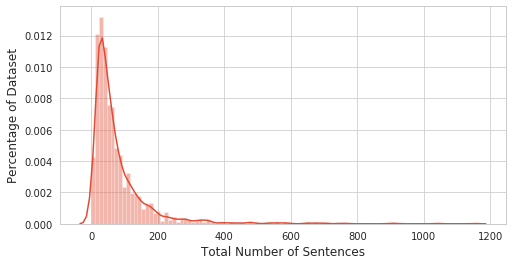

In [10]:
fig, ax = plt.subplots(figsize=(8,4))
sns.distplot(review_words, bins=100)
ax.set(xlabel= "Total Number of Sentences", ylabel="Percentage of Dataset")
plt.show()

In [11]:
sum(review_words <= 17.5)/1875, sum(review_words <= 35)/1875

(0.06506666666666666, 0.34026666666666666)

In [12]:
review_words.mean()

80.60693333333333

Less than 7% have a review that is shorter than the average sentence, and 34% have a review shorter than two average sentences. I believe this will be barely enough to draw inferences based on the size of the dataset, but it should still be enough.

In [13]:
df['review_wordcount'] = review_words
df_obj = ['marketplace', 'customer_id', 'review_id', 'product_id', 'verified_purchase',
          'review_headline', 'review_body']
df_num = df[['star_rating', 'helpful_votes', 'total_votes', 'review_date', 'review_wordcount']]

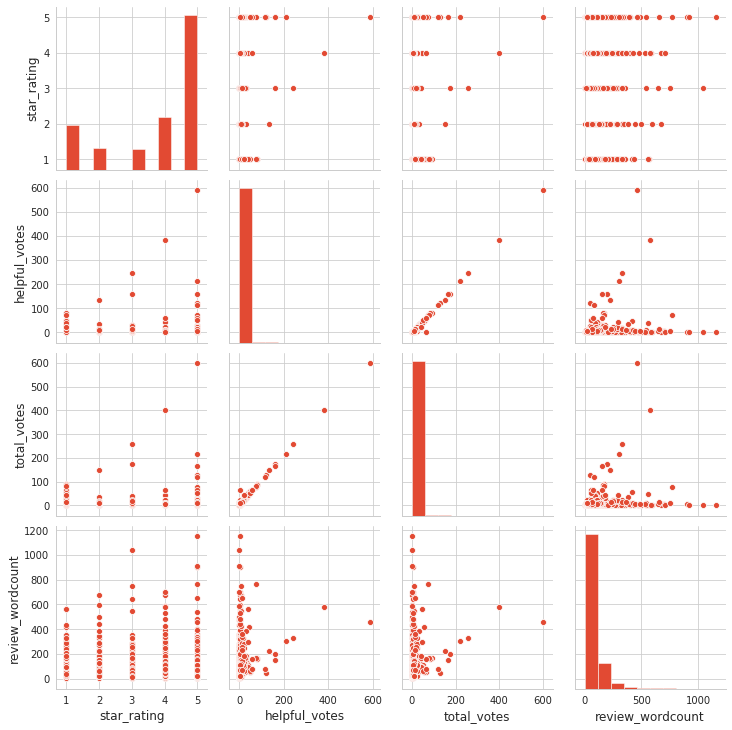

In [14]:
sns.pairplot(df_num)

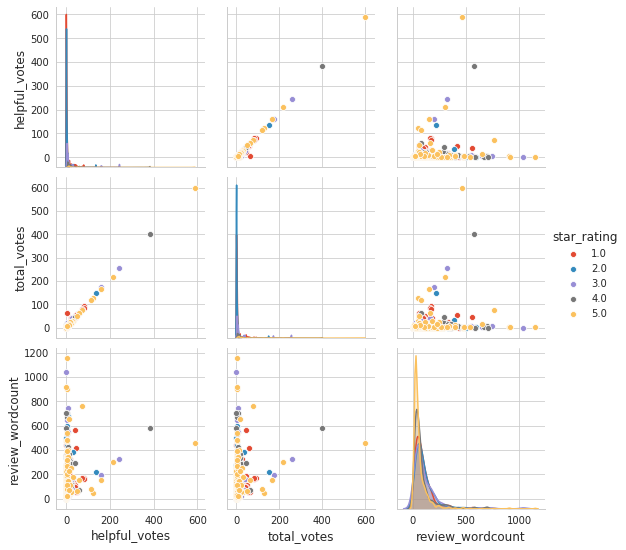

In [15]:
sns.pairplot(df_num, hue='star_rating')

In [16]:
df.drop('marketplace', axis = 1, inplace = True)
df.drop('product_parent', axis = 1, inplace = True)
df.drop('product_title', axis = 1, inplace = True)
df.drop('product_category', axis = 1, inplace = True)
df.drop('vine', axis = 1, inplace = True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1875 entries, 0 to 1874
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        1875 non-null   int64         
 1   review_id          1875 non-null   object        
 2   product_id         1875 non-null   object        
 3   star_rating        1875 non-null   float64       
 4   helpful_votes      1875 non-null   float64       
 5   total_votes        1875 non-null   float64       
 6   verified_purchase  1875 non-null   object        
 7   review_headline    1875 non-null   object        
 8   review_body        1875 non-null   object        
 9   review_date        1875 non-null   datetime64[ns]
 10  review_wordcount   1875 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 161.3+ KB


In [18]:
def clean_review(row):
    '''
    Given a row, this function removes html tags in case they exist within our reviews
    '''
    soup = BeautifulSoup(row['review_body'], "lxml")
    return soup.get_text()

In [19]:
df['clean_review'] = df.apply(clean_review, axis=1)

In [20]:
df.to_csv("modeling_ready_microwave1", index=False)